# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

### Exercise 11.1

The goal of the first assignment of this exercise sheet is to fit a linear function:

$$f(x)=2x+1$$

using a neural network. In the following, we refer to this linear function as the **true model**. Here, we define a Python function to compute the value of our true model at an arbitrary feature value $x$:

In [2]:
# true model
def f_linear(x):
    return 2 * x + 1

We will concentrate on features $x\in[-1, 1]$. Hence, $f: [-1, 1] \rightarrow [-1, 3], x \mapsto 2x+1$. In the next Jupyter cell, we define a Python function to generate $N_{train}$ training examples and $N_{test}$ test examples from our true model $f$. The function is also able to handle true models with more than one feature. The features are drawn uniformly in the specified feature space. The labels are drawn from a Gaussian distribution with mean $0.0$ and standard deviation $\sigma$. The Gaussian distribution of the labels implements the statistical uncertainty of measurements in reality.

In [3]:
import numpy as np

# set seed
np.random.seed(0)

def gen_data(f, N_train, N_test, sigma, x_min=(-1,), x_max=(1,)):
    """
    Generate training and test examples from true model f.
    Min. and max. values specify the feature space.
    Feature values are drawn uniformly from the feature space.
    Labels are drawn from a Gaussian distribution with mean 0.0 and standard deviation sigma.
    """

    n_dim = len(x_min)  # dimension of feature space
    
    x_train = np.zeros([N_train, n_dim])
    x_test = np.zeros([N_test, n_dim])
    
    # draw features
    for i in range(n_dim):
        x_train[:, i] = np.random.uniform(x_min[i], x_max[i], N_train)
        x_test[:, i] = np.random.uniform(x_min[i], x_max[i], N_test)
    
    # draw labels
    y_train = np.random.normal(f(x_train), sigma)
    y_test = np.random.normal(f(x_test), sigma)
    
    return x_train, y_train, x_test, y_test

Now, that we are able to generate training and test examples, we have to initialize our neural network. Since the feature space is one-dimensional, we only need a single neuron with an identity activation function to perform a linear regression. This means that we do not have any hidden layers and that the input layer coincides with the output layer. As the optimizer of the neural network we use stochastic gradient descent (sgd). In this case, we are interest in minimizing the so-called **sum of the mean square-error (MSE)**:

$$ MSE= \frac{1}{N}\sum_{j=1}^{N} (y_j^\mathrm{pred}-y_j)^2.$$

Here, $N$ is the number of examples that are part of the computation of the MSE. When we train our model using our training examples $(x_{train}, y_{train})$, $N$ is $N_{train}$. In the training phase, the optimizer tries to find parameters (in this case the slope $m_{fit}$ and the intercept $b_{fit}$) that minimize the MSE w.r.t. the training set. For the evaluation of the obtained fit, the MSE is computed w.r.t to the training set. The next panel shows the initialization of the neural network:

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

The training of our neural network (containing only one neuron with an identity activation function) depends on a variaty of parameters. Among these, we have the number of epochs $N_{epochs}$ that describes, how often the whole training set is passed through the neural network. For the batch size, we leave the Keras standard setting $N_{batches}=32$. Another parameters regard the data points themselves. Here, we can vary the number of training examples $N_{train}$ and the noise of the labels $\sigma$.

Throughout this first exercise, we use $N_{test} = 64$ test examples. 

We start with the analysis of the dependence of the fit quality on the number of epochs $N_{epochs}$. For this purpose, we set $N_{train} = 256$ and $\sigma = 0.0$ (as we only want to examine the depedence on the epoch size $N_{epochs}$).

In the figure below, we visualize the how the test and the training MSE decrease with increasing number of epochs $N_{epochs}$. So, the predictive quality of our neural network increases significantly with the number of epochs $N_{epochs}$. This suggests that a neural network retrieves gradually information from the training data. In this sense, the term "machine learning" becomes clear. In this example, where the true model is a linear relationship without any noise, in principal, the neural network is able to find good estimates $m_{fit}$ and $b_{fit}$ even with only $2$ training examples. However, this is a particular simple case that would probably never happen in real applications of neural networks. It can also be observed that the training MSE is typically (at least for a low number of epochs) slightly larger than the test MSE as expected.

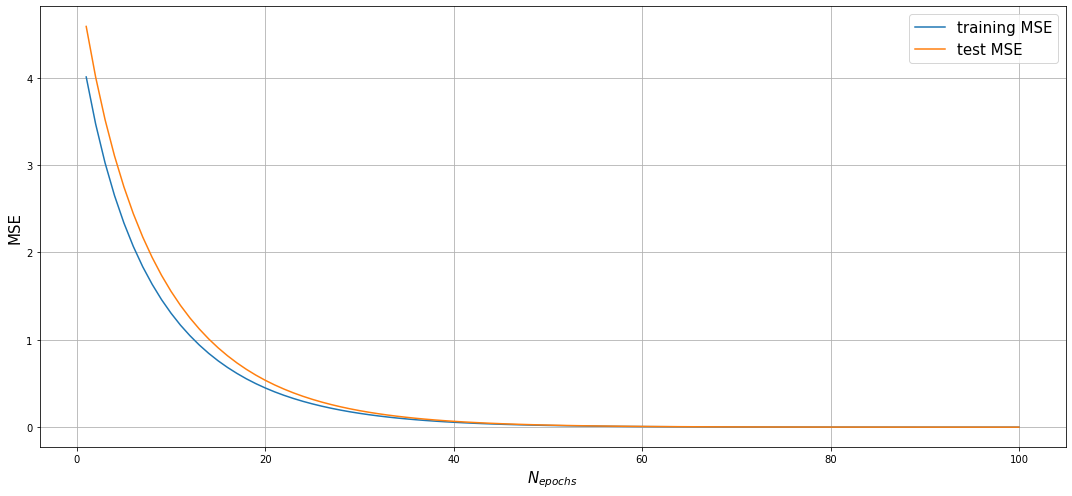

In [5]:
import matplotlib.pyplot as plt

N_epochs = 100  # total number of epochs

N_train = 256
N_test = 64
sigma = 0.0

# generate training and test examples from true model
x_train, y_train, x_test, y_test = gen_data(f_linear, N_train, N_test, sigma)

# initialize untrained NN
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# lists to store parameters for every epoch
m_fit = []
b_fit = []

# corresponding callback functions
slope_callback = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: m_fit.append(model.get_weights()[0][0][0]))
intercept_callback = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: b_fit.append(model.get_weights()[1][0]))

# fit model to data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=N_epochs,
          shuffle=True,
          validation_data=(x_test, y_test),
          verbose=0,
          callbacks=[slope_callback, intercept_callback])

# plot training and test MSE against epoch number
x = np.arange(1, N_epochs + 1)
plt.figure(figsize=(15, 7))
plt.plot(x, history.history["mse"], label="training MSE")
plt.plot(x, history.history["val_mse"], label="test MSE")
plt.xlabel(r"$N_{epochs}$", size=15)
plt.ylabel("MSE", size=15)
plt.legend(fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In particular, the next figure shows that the fitted parameters $m_{fit}$ and $b_{fit}$ tend towards their true values as we increase the number of epochs $N_{epochs}$ of our neural network. Note, that the number of epochs that are needed for convergence to the true parameters varies from execution to execution of this Pyhton script as Keras/Tensorflow assigns random starting weights.

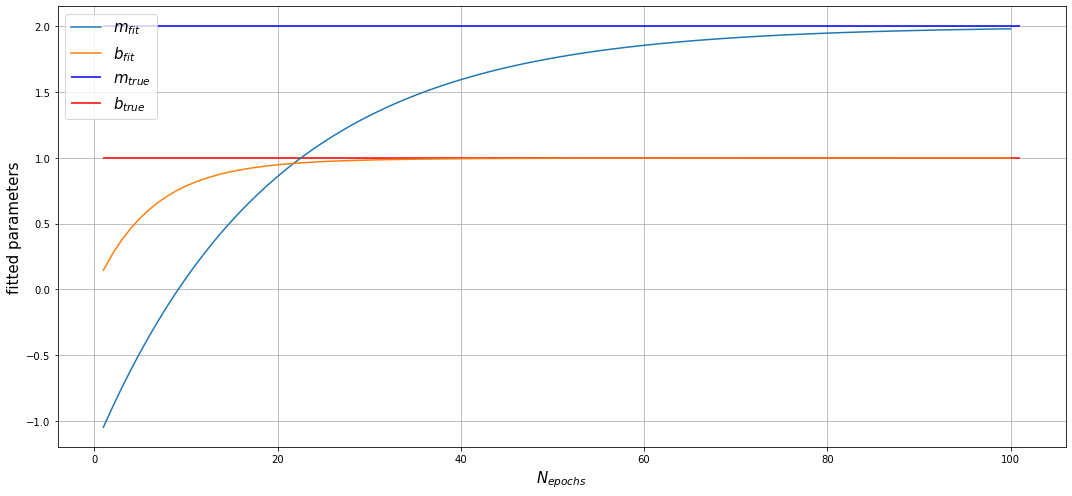

In [6]:
plt.figure(figsize=(15, 7))

plt.plot(x, m_fit, label=r"$m_{fit}$")
plt.plot(x, b_fit, label=r"$b_{fit}$")
plt.hlines(2, 1, N_epochs + 1, label=r"$m_{true}$", color="blue")
plt.hlines(1, 1, N_epochs + 1, label=r"$b_{true}$", color="red")

plt.xlabel(r"$N_{epochs}$", size=15)
plt.ylabel("fitted parameters", size=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

Next, we want to investigate how the fit performance depends on the number of training examples $N_{train}$ that we use to train our neural network. For this purpose, we use $N_{epochs} = 50$ and $N_{batches} = 32$ (which is the Keras standard setting). The results for four different number of training examples $N_{train}$ are displayed in the next figure. The panels on the lefthand side show the linear function from the fit (parametrized by $m_{fit}$ and $b_{fit}$) as well as the true model (parametrized by $m_{true}$ and $b_{true}$). The righthand side panels report the MSE w.r.t. to  the training and test set. As we increase the number of training examples $N_{train}$, the accuraccy of the fit increase. It is also clearly visible that the MSE of the fit decreases more rapidly with the number of epochs $N_{epochs}$ as we include more training examples. In other words, more training examples and less epochs or less training examples and more epochs seem to lead to similar results of the fit.

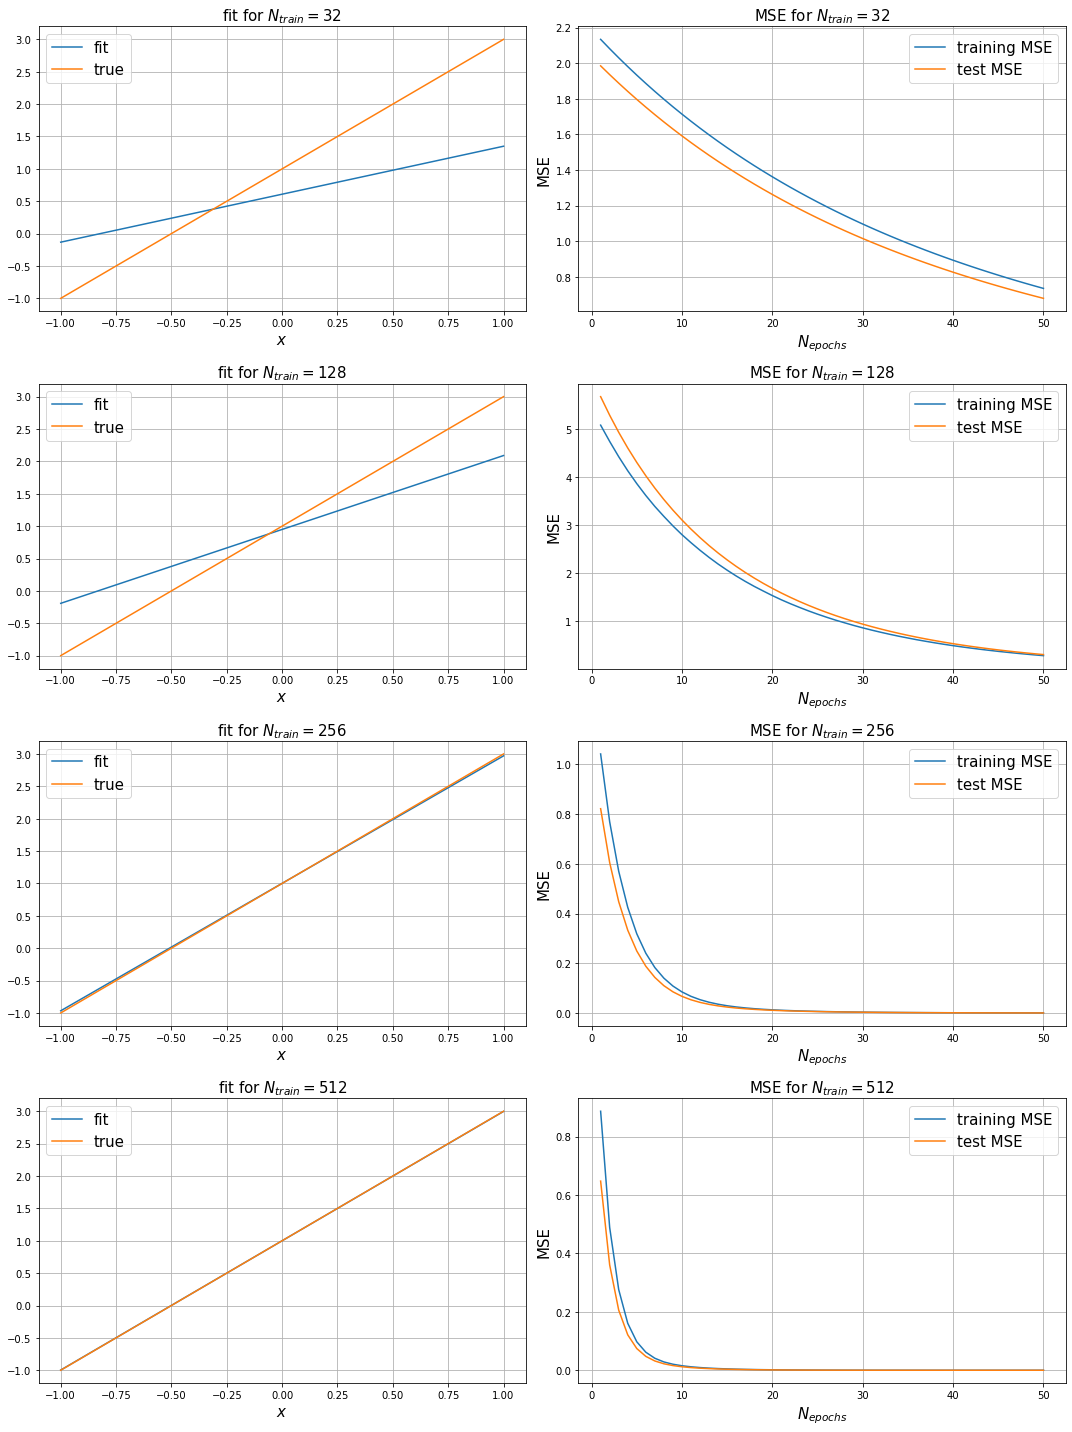

In [7]:
N_train = [32, 128, 256, 512]
N_test = 64
sigma = 0.0

N_epochs = 50

x = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(len(N_train), 2, figsize=(15, 20))

for i in range(len(N_train)):
    # generate training and test examples from true model
    x_train, y_train, x_test, y_test = gen_data(f_linear, N_train[i], N_test, sigma)

    # initialize untrained NN
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,)))
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    
    # fit model to data
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=N_epochs,
              shuffle=True,
              validation_data=(x_test, y_test),
              verbose=0)
    
    m_fit = model.get_weights()[0][0]
    b_fit = model.get_weights()[1][0]
    
    # plot linear fit and true model
    ax[i, 0].plot(x, m_fit * x + b_fit, label="fit")
    ax[i, 0].plot(x, f_linear(x), label="true")
    ax[i, 0].legend(fontsize=15)
    ax[i, 0].set_xlabel("$x$", size=15)
    ax[i, 0].set_title("fit for $N_{train} = $" + str(N_train[i]), size=15)
    ax[i, 0].grid()
    
    # plot MSE
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
    ax[i, 1].legend(fontsize=15)
    ax[i, 1].set_xlabel("$N_{epochs}$", size=15)
    ax[i, 1].set_ylabel("MSE", size=15)
    ax[i, 1].set_title("MSE for $N_{train} = $" + str(N_train[i]), size=15)
    ax[i, 1].grid()
    
plt.tight_layout()
plt.show()

Finally, we include a Gaussian noise to our training and test data. Here, we keep $N_{epochs}=50$ and $N_{batches}=32$. We use $N_{train}=512$ training examples. The results are displayed in the figure below. Here, we also plot the test examples to illustrate the implemented amount of noise $\sigma$. We observe that the fit of our neural network is considerably robust as the fit is always in high agreement with the true model. Notably, the MSE for both the training and test set is generally larger for a larger noise value $\sigma$ because the data points are in general farer away from the true model.

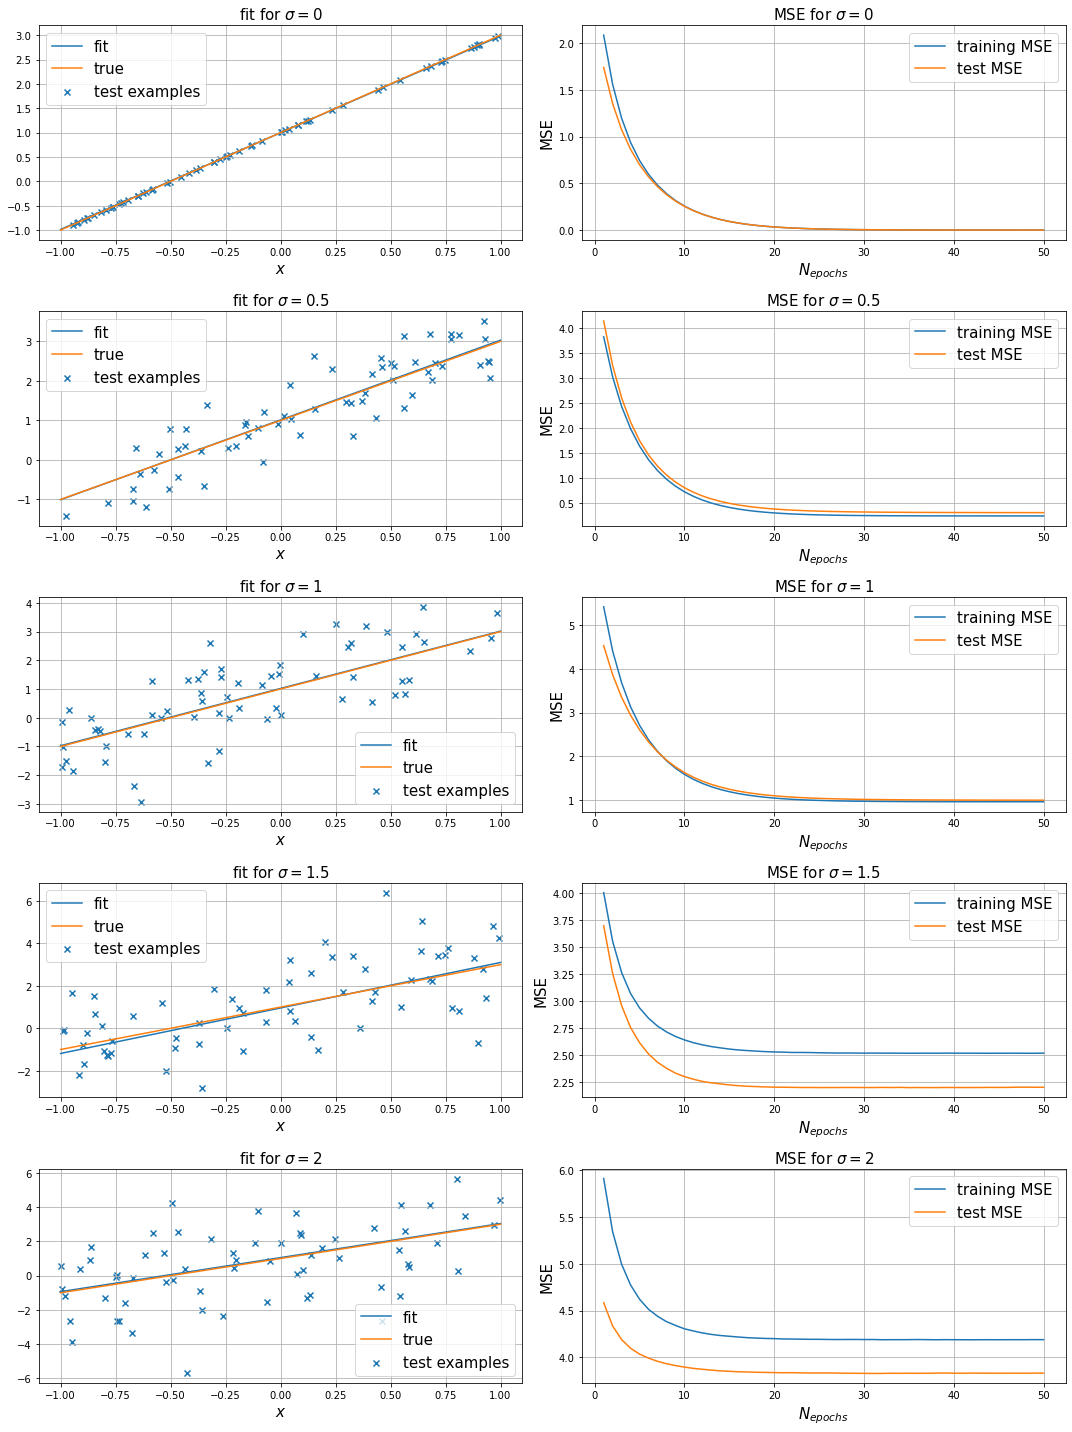

In [8]:
N_train = 512
N_test = 64
sigma = [0, 0.5, 1, 1.5, 2]

N_epochs = 50

x = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(len(sigma), 2, figsize=(15, 20))

for i in range(len(sigma)):
    # generate training and test examples from true model
    x_train, y_train, x_test, y_test = gen_data(f_linear, N_train, N_test, sigma[i])

    # initialize untrained NN
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,)))
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    
    # fit model to data
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=N_epochs,
              shuffle=True,
              validation_data=(x_test, y_test),
              verbose=0)
    
    m_fit = model.get_weights()[0][0]
    b_fit = model.get_weights()[1][0]
    
    # plot training data
    ax[i, 0].scatter(x_test, y_test, label="test examples", marker="x")
    
    # plot linear fit and true model
    ax[i, 0].plot(x, m_fit * x + b_fit, label="fit")
    ax[i, 0].plot(x, f_linear(x), label="true")
    ax[i, 0].legend(fontsize=15)
    ax[i, 0].set_xlabel("$x$", size=15)
    ax[i, 0].set_title("fit for $\sigma = $" + str(sigma[i]), size=15)
    ax[i, 0].grid()
    
    # plot MSE
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
    ax[i, 1].legend(fontsize=15)
    ax[i, 1].set_xlabel("$N_{epochs}$", size=15)
    ax[i, 1].set_ylabel("MSE", size=15)
    ax[i, 1].set_title("MSE for $\sigma = $" + str(sigma[i]), size=15)
    ax[i, 1].grid()
    
plt.tight_layout()
plt.show()

### Exercise 11.2

In the second assignment of this exercise sheet, we expand our neural network in order to fit a polynomial of order $3$:

$$ f(x)=4-3x-2x^2+3x^3.$$

Again, we focus on taking training examples from the range $x \in [-1, 1]$. However, we do check the quality of our fit outside this range, i.e. we analyze how well our neural network is able to perform extrapolation. In the next cell we define the necessary Python function:

In [9]:
def f_poly(x):
    return 4 - 3 * x - 2 * x**2 + 3 * x**3

In order to develop our neural network, we fix $N_{epochs} = 30$, $N_{batches} = 32$ and $N_{train} = 2048$. As above, we use $N_{test} = 64$ test examples. In addition, we implement a modest noise using $\sigma = 0.25$ to simulate realistic data. First, let us define some variables and generate the data:

In [10]:
N_epochs = 30
N_batches = 32
N_train = 2048
N_test = 64
sigma = 0.25

# generate training and test examples from true model
x_train, y_train, x_test, y_test = gen_data(f_poly, N_train, N_test, sigma, (-1,), (1,))

First, we analyze the effect of the structure of our neural network in terms of hidden layers and neurons. Below, we plot the fit and the true model as well as the training and test MSE. In the top panel, the results for a neural network with just one hidden layer with $100$ neurons are displayed. The fit reflects the general form of the true model and is an application of the general approximation theorem. The general approximation theorem states that (almost) every function can be approximated with arbitrary precision by training a neural network with just one hidden layer. However, the convergence to the true model w.r.t. the number of neurons in that hidden layer is slow. For the other neural networks, we observe that the fit quality as well as the test MSE decreases when we add more hidden layers and neurons. All neural networks perform poorly outside the training range $x\in[-1, 1]$. This is a well reported empirical observation for neural networks applied for regression.

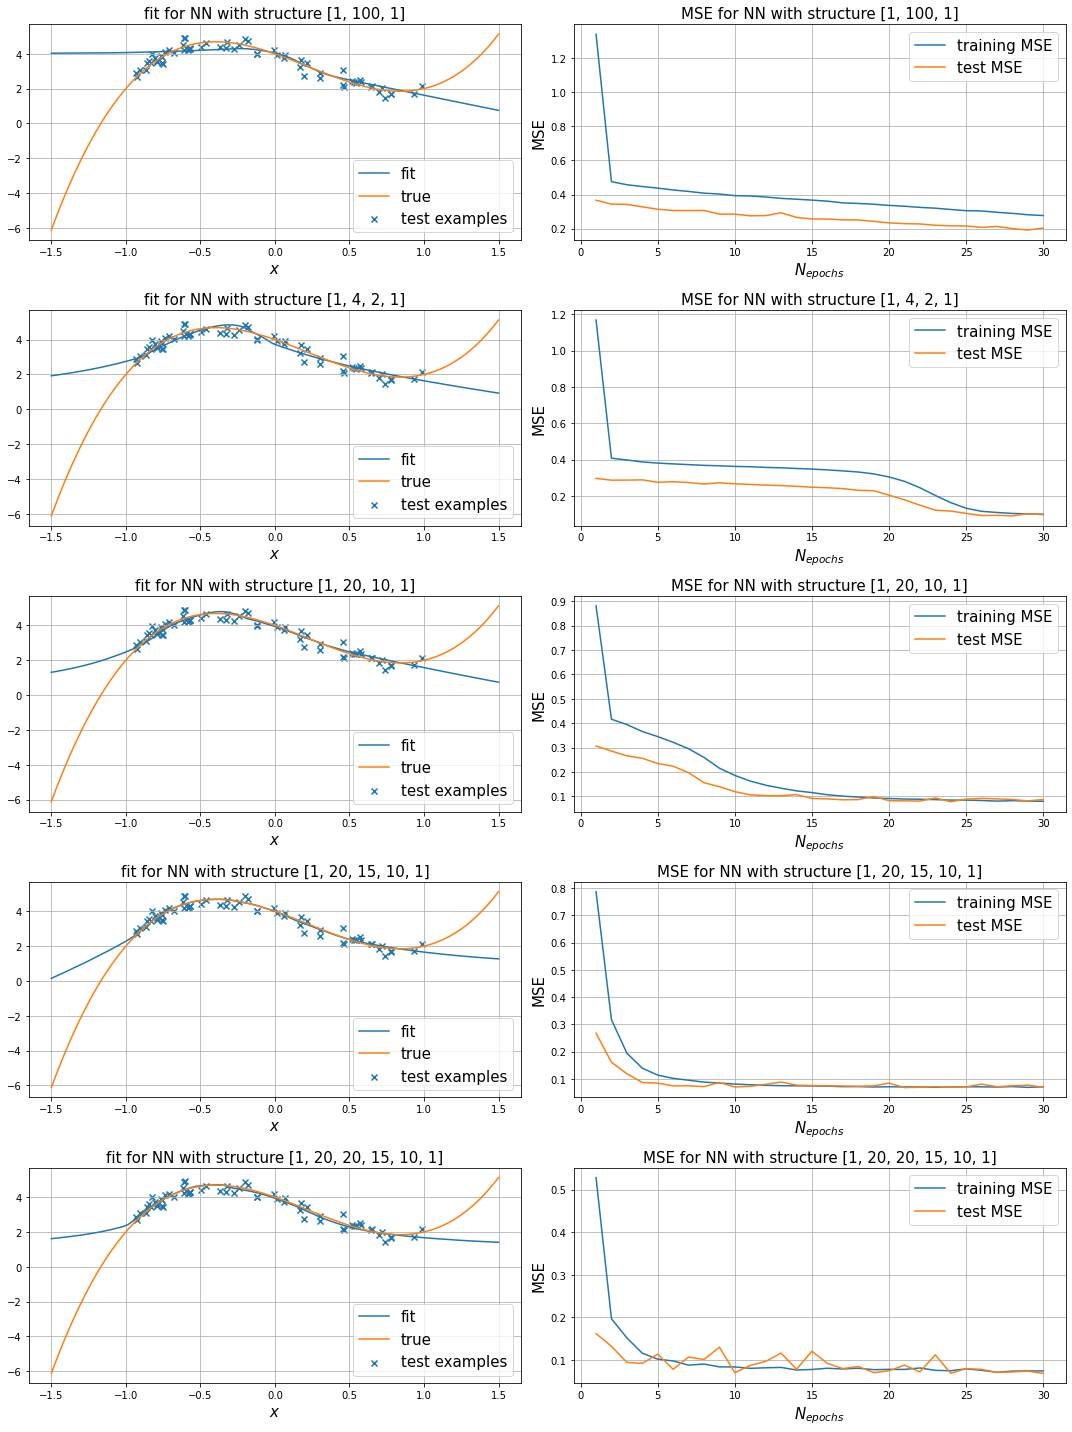

In [11]:
model_list = [] # list to store different NN architectures (all with relu activation function)
title_list = ["[1, 100, 1]", "[1, 4, 2, 1]", "[1, 20, 10, 1]", "[1, 20, 15, 10, 1]", "[1, 20, 20, 15, 10, 1]"]

actfunc = "selu"

# first model
model1 = tf.keras.Sequential()
model1.add(Dense(1, input_shape=(1,), activation="selu"))
model1.add(Dense(100, activation="selu"))
model1.add(Dense(1))
model_list.append(model1)

# second model
model2 = tf.keras.Sequential()
model2.add(Dense(1, input_shape=(1,), activation="selu"))
model2.add(Dense(4, activation="selu"))
model2.add(Dense(2, activation="selu"))
model2.add(Dense(1))
model_list.append(model2)

# third model
model3 = tf.keras.Sequential()
model3.add(Dense(1, input_shape=(1,), activation="selu"))
model3.add(Dense(20, activation="selu"))
model3.add(Dense(10, activation="selu"))
model3.add(Dense(1))
model_list.append(model3)

# fourth model
model4 = tf.keras.Sequential()
model4.add(Dense(1, input_shape=(1,), activation="selu"))
model4.add(Dense(20, activation="selu"))
model4.add(Dense(15, activation="selu"))
model4.add(Dense(10, activation="selu"))
model4.add(Dense(1))
model_list.append(model4)

# fifth model
model5 = tf.keras.Sequential()
model5.add(Dense(1, input_shape=(1,), activation="selu"))
model5.add(Dense(20, activation="selu"))
model5.add(Dense(20, activation="selu"))
model5.add(Dense(15, activation="selu"))
model5.add(Dense(10, activation="selu"))
model5.add(Dense(1))
model_list.append(model5)

fig, ax = plt.subplots(len(model_list), 2, figsize=(15, 20))
x_plot = np.linspace(-1.5, 1.5, 100)

for i, model in enumerate(model_list):
    
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    
    # fit model to data
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=N_epochs,
              shuffle=True,
              validation_data=(x_test, y_test),
              verbose=0)

    # compute prediction and true model
    y_true = f_poly(x_plot)
    y_predict = model.predict(x_plot)
    
    # plot fit, true model and test examples
    ax[i, 0].plot(x_plot, y_predict, label="fit")
    ax[i, 0].plot(x_plot, y_true, label="true")
    ax[i, 0].scatter(x_test, y_test, marker="x", label="test examples")
    ax[i, 0].legend(fontsize=15)
    ax[i, 0].set_xlabel("$x$", size=15)
    ax[i, 0].set_title("fit for NN with structure " + title_list[i], size=15)
    ax[i, 0].grid()
    
    # plot MSE
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
    ax[i, 1].legend(fontsize=15)
    ax[i, 1].set_xlabel("$N_{epochs}$", size=15)
    ax[i, 1].set_ylabel("MSE", size=15)
    ax[i, 1].set_title("MSE for NN with structure " + title_list[i], size=15)
    ax[i, 1].grid()
    
plt.tight_layout()
plt.show()

In the next figure, we examine how the choice of the activation function for the neurons affects the results of the fit of our true model with our neural network. As we can see, the relu-, elu- and the selu-function lead to good results. For the softplus-function, the convergence as a function of the number of epochs $N_{epochs}$ seems to be slower than for the other activation functions. The neural network that applies a linear activation is only able to predict a linear relationship.

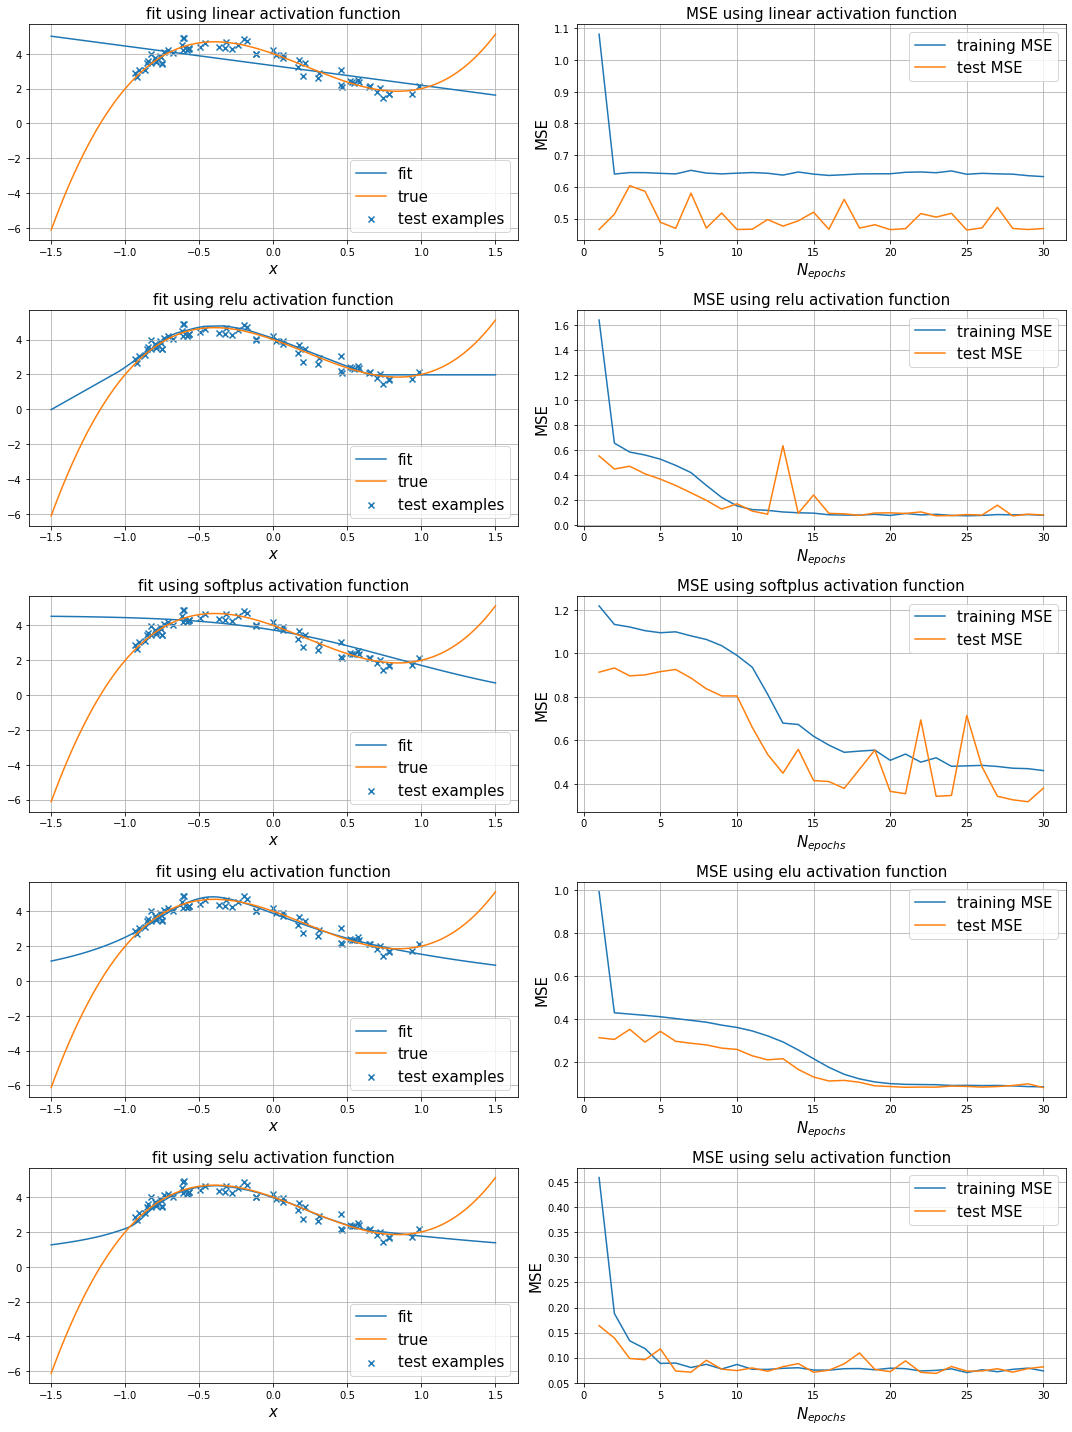

In [12]:
actfunc_list = ["linear", "relu", "softplus", "elu", "selu"] # list of different activation functions

fig, ax = plt.subplots(len(actfunc_list), 2, figsize=(15, 20))
x_plot = np.linspace(-1.5, 1.5, 100)

for i, actfunc in enumerate(actfunc_list):

    # model
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,), activation=actfunc))
    model.add(Dense(20, activation=actfunc))
    model.add(Dense(20, activation=actfunc))
    model.add(Dense(15, activation=actfunc))
    model.add(Dense(10, activation=actfunc))
    model.add(Dense(1))
    
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    
    # fit model to data
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=N_epochs,
              shuffle=True,
              validation_data=(x_test, y_test),
              verbose=0)
    
    # compute prediction and true model
    y_true = f_poly(x_plot)
    y_predict = model.predict(x_plot)
    
    # plot fit, true model and test examples
    ax[i, 0].plot(x_plot, y_predict, label="fit")
    ax[i, 0].plot(x_plot, y_true, label="true")
    ax[i, 0].scatter(x_test, y_test, marker="x", label="test examples")
    ax[i, 0].legend(fontsize=15)
    ax[i, 0].set_xlabel("$x$", size=15)
    ax[i, 0].set_title("fit using " + actfunc + " activation function", size=15)
    ax[i, 0].grid()
    
    # plot MSE
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
    ax[i, 1].legend(fontsize=15)
    ax[i, 1].set_xlabel("$N_{epochs}$", size=15)
    ax[i, 1].set_ylabel("MSE", size=15)
    ax[i, 1].set_title("MSE using " + actfunc + " activation function", size=15)
    ax[i, 1].grid()
    
plt.tight_layout()
plt.show()    

Next, we can also chose different procedures to optimize the weights of our neural network. We observe that stochastic gradient descent leads to the best (and fastest) results, followed by Adam. The Adadelta optimizer leads to poor results.

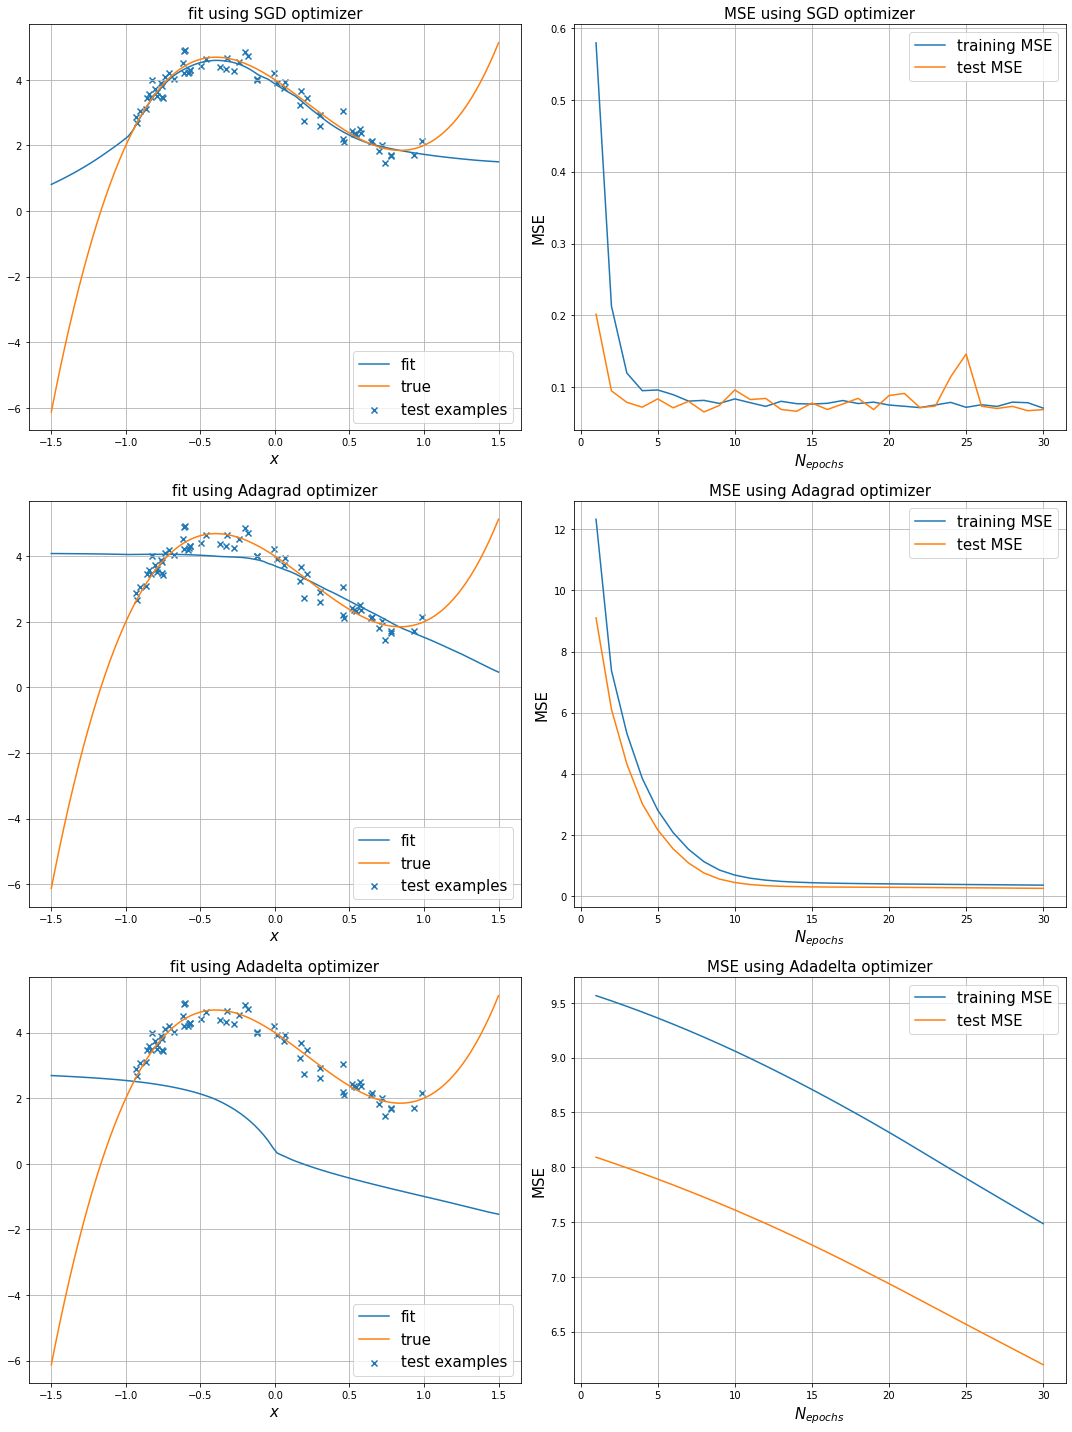

In [13]:
opt_list = ["SGD", "Adagrad", "Adadelta"] # list of different optimizers
actfunc = "selu"

fig, ax = plt.subplots(len(opt_list), 2, figsize=(15, 20))
x_plot = np.linspace(-1.5, 1.5, 100)

for i, opt in enumerate(opt_list):

    # model
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,), activation=actfunc))
    model.add(Dense(20, activation=actfunc))
    model.add(Dense(20, activation=actfunc))
    model.add(Dense(15, activation=actfunc))
    model.add(Dense(10, activation=actfunc))
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    
    # fit model to data
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=N_epochs,
              shuffle=True,
              validation_data=(x_test, y_test),
              verbose=0)
    
    # compute prediction and true model
    y_true = f_poly(x_plot)
    y_predict = model.predict(x_plot)
    
    # plot fit, true model and test examples
    ax[i, 0].plot(x_plot, y_predict, label="fit")
    ax[i, 0].plot(x_plot, y_true, label="true")
    ax[i, 0].scatter(x_test, y_test, marker="x", label="test examples")
    ax[i, 0].legend(fontsize=15)
    ax[i, 0].set_xlabel("$x$", size=15)
    ax[i, 0].set_title("fit using " + opt + " optimizer", size=15)
    ax[i, 0].grid()
    
    # plot MSE
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
    ax[i, 1].legend(fontsize=15)
    ax[i, 1].set_xlabel("$N_{epochs}$", size=15)
    ax[i, 1].set_ylabel("MSE", size=15)
    ax[i, 1].set_title("MSE using " + opt + " optimizer", size=15)
    ax[i, 1].grid()
    
plt.tight_layout()
plt.show()    

Finally, different losses - that tell us what is a "good" prediction - can be applied. Among those analyzed in the next figure, all of them except the mean squared logarithmic error lead to similar results.

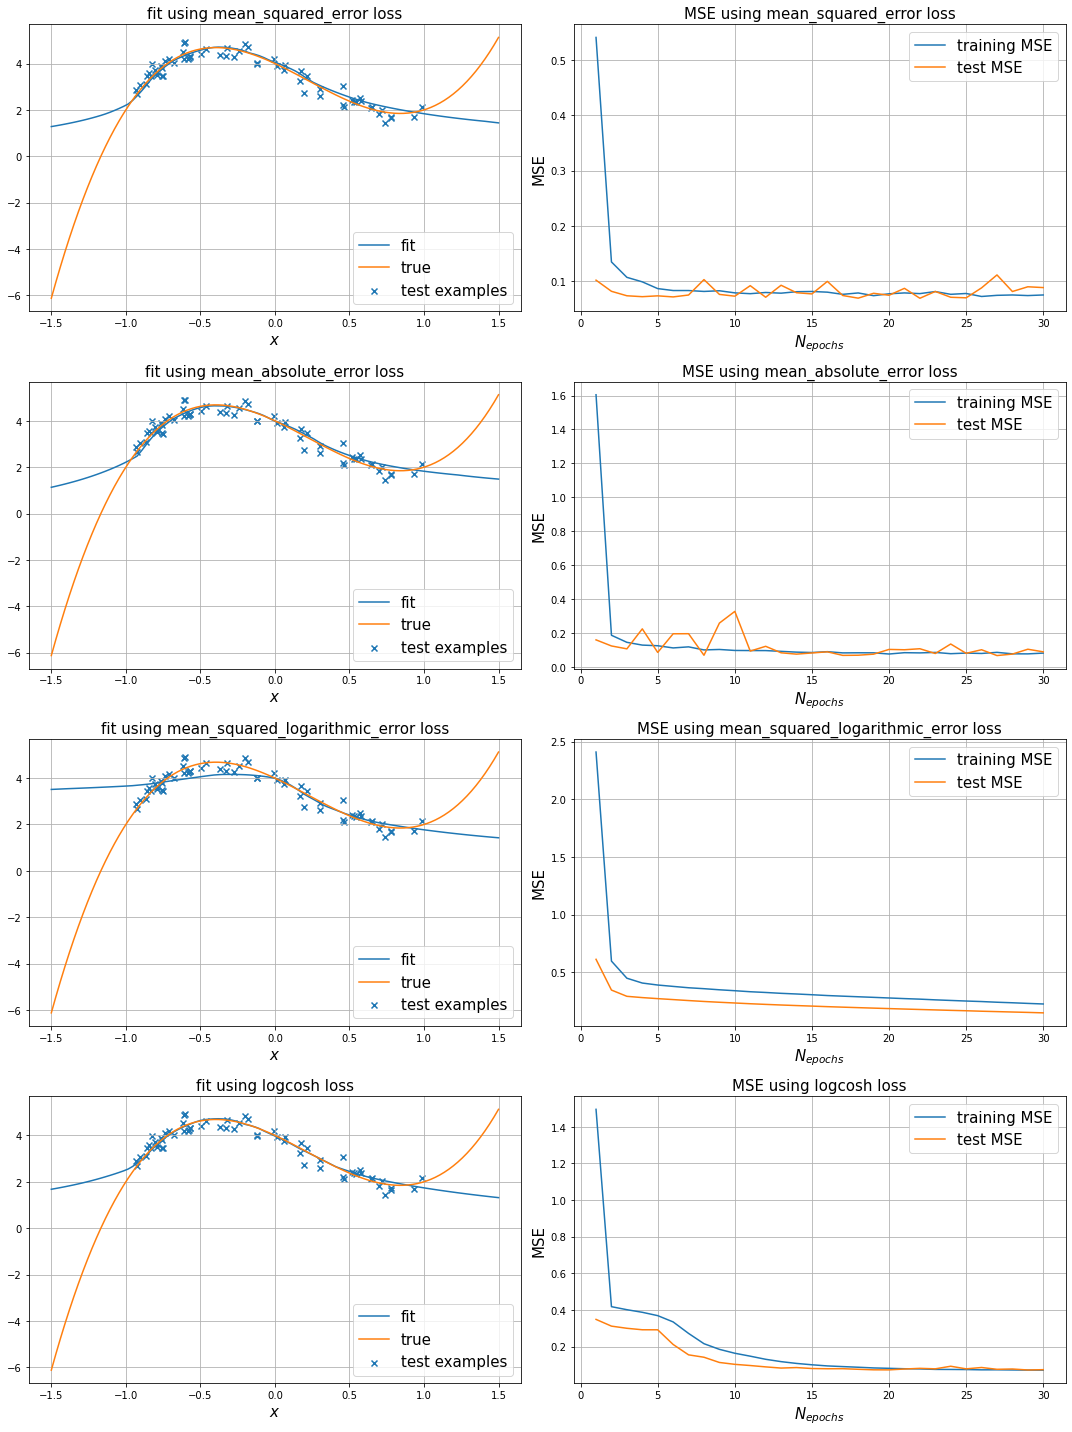

In [14]:
loss_list = ["mean_squared_error", "mean_absolute_error", "mean_squared_logarithmic_error", "logcosh"] # list of different losses
actfunc = "selu"
opt = "sgd"

fig, ax = plt.subplots(len(loss_list), 2, figsize=(15, 20))
x_plot = np.linspace(-1.5, 1.5, 100)

for i, loss in enumerate(loss_list):

    # model
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,), activation=actfunc))
    model.add(Dense(20, activation=actfunc))
    model.add(Dense(20, activation=actfunc))
    model.add(Dense(15, activation=actfunc))
    model.add(Dense(10, activation=actfunc))
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss=loss, metrics=['mse'])
    
    # fit model to data
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=N_epochs,
              shuffle=True,
              validation_data=(x_test, y_test),
              verbose=0)
    
    # compute prediction and true model
    y_true = f_poly(x_plot)
    y_predict = model.predict(x_plot)
    
    # plot fit, true model and test examples
    ax[i, 0].plot(x_plot, y_predict, label="fit")
    ax[i, 0].plot(x_plot, y_true, label="true")
    ax[i, 0].scatter(x_test, y_test, marker="x", label="test examples")
    ax[i, 0].legend(fontsize=15)
    ax[i, 0].set_xlabel("$x$", size=15)
    ax[i, 0].set_title("fit using " + loss + " loss", size=15)
    ax[i, 0].grid()
    
    # plot MSE
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
    ax[i, 1].plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
    ax[i, 1].legend(fontsize=15)
    ax[i, 1].set_xlabel("$N_{epochs}$", size=15)
    ax[i, 1].set_ylabel("MSE", size=15)
    ax[i, 1].set_title("MSE using " + loss + " loss", size=15)
    ax[i, 1].grid()
    
plt.tight_layout()
plt.show()    

All in all, the accuracy of the fit of the neural network, and thus its predictions, depend strongly on the structure of the neural network that is determined by the number of hidden layers and by the number of neurons. Also, the choice of the activation function as well as the optimizer have an influence on the result and on the convergence in terms of the number of epochs $N_{epoch}$. Finally, the fit of the neural network depends on the loss function as the loss function describes which prediction is "good". Outside of the range $x \in [-1, 1]$, the neural network makes poor predictions that are barely useful.

### Exercise 11.3

In the last assignment of this exercise sheet, we want to fit the more complex function:

$$ f(x, y) = \sin(x^2+y^2).$$

We are interested in the interval $x\in[-3/2,3/2]$ and $y\in[-3/2,3/2]$. 

First, we generate the training and test examples from $f_{2D}$:

In [15]:
N_train = 1028
N_test = 5120
sigma = 0.25

def f_2D(x):
    return np.sin(x[:, 0]**2 + x[:, 1]**2)

# generate training and test examples from true model
x_train, y_train, x_test, y_test = gen_data(f_2D, N_train, N_test, sigma, (-1.5,-1.5), (1.5,1.5))

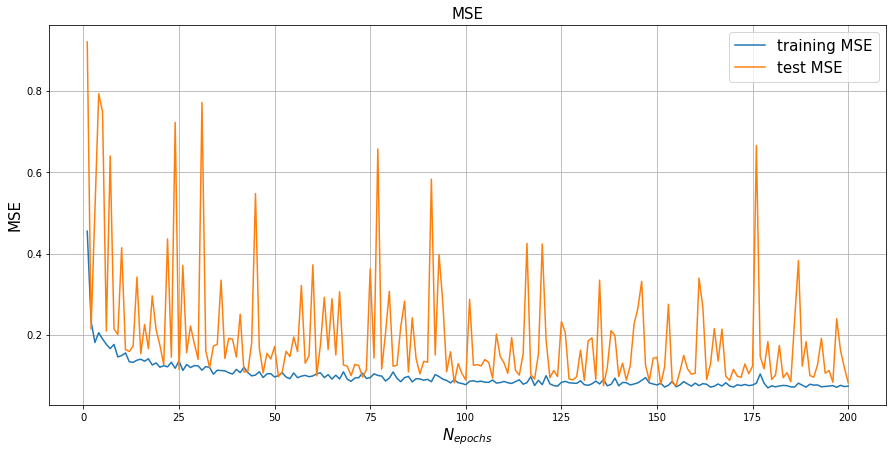

In [37]:
actfunc = "selu"
opt = "sgd"
loss = "MSE"
N_epochs = 200

# model
model = tf.keras.Sequential()
model.add(Dense(150, input_shape=(2,), activation=actfunc))
model.add(Dense(150, activation=actfunc))
model.add(Dense(50, activation=actfunc))
model.add(Dense(30, activation=actfunc))
model.add(Dense(1, activation=actfunc))
model.add(Dense(1))

model.compile(optimizer=opt, loss=loss, metrics=['mse'])

# fit model to data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=N_epochs,
          shuffle=True,
          validation_data=(x_test, y_test),
          verbose=0)

# plot MSE
plt.figure(figsize=(15, 7))
plt.plot(np.arange(1, N_epochs + 1), history.history["mse"], label="training MSE")
plt.plot(np.arange(1, N_epochs + 1), history.history["val_mse"], label="test MSE")
plt.legend(fontsize=15)
plt.xlabel("$N_{epochs}$", size=15)
plt.ylabel("MSE", size=15)
plt.title("MSE", size=15)
plt.grid()

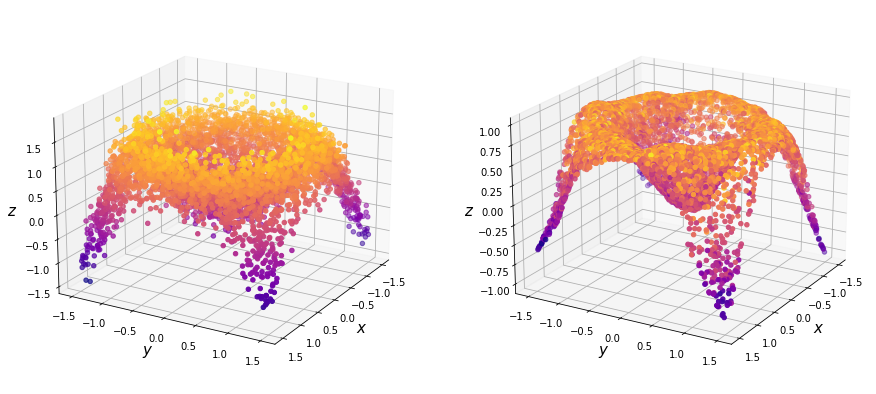

In [38]:
from mpl_toolkits.mplot3d import Axes3D

y_pred = model.predict(x_test)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(x_test[:,0], x_test[:,1], y_test, c=y_test, cmap='plasma')
ax.set_xlabel("$x$", size=15)
ax.set_ylabel("$y$", size=15)
ax.set_zlabel("$z$", size=15)
ax.view_init(20, 30)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(x_test[:,0], x_test[:,1], y_pred, c=y_test, cmap='plasma')
ax.set_xlabel("$x$", size=15)
ax.set_ylabel("$y$", size=15)
ax.set_zlabel("$z$", size=15)
ax.view_init(20, 30)

plt.show()